# OpenPIV tutorial 1


In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [25]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

In [26]:
frame_a  = tools.imread( '../../examples/test1/exp1_001_a.bmp' )
frame_b  = tools.imread( '../../examples/test1/exp1_001_b.bmp' )

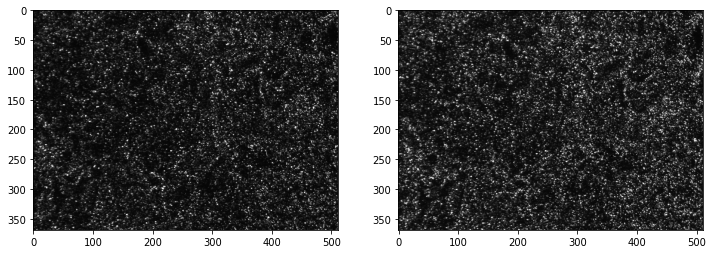

In [27]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [28]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 0.02 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [29]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [30]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [31]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)


In [32]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 96.52 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [33]:
#save in the simple ASCII table format
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

FileNotFoundError: No such file: '/home/miotto/.local/share/Trash/files/openpiv-python/openpiv/docs/test1/exp1_001_a.bmp'

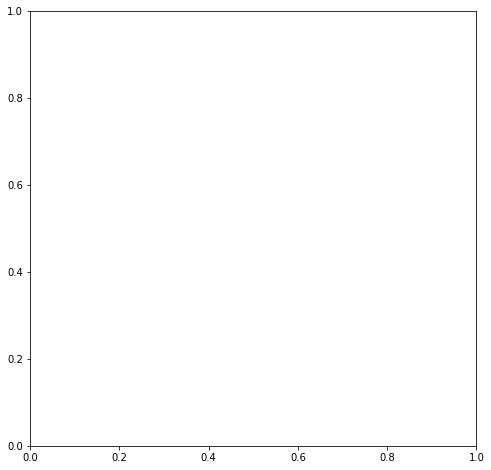

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='../../examples/test1/exp1_001_a.bmp');

## One could also use some shortcuts

In [ ]:

from openpiv import piv
piv.simple_piv(frame_a, frame_b);

In [ ]:
piv.piv_example();